In [1]:
import torch
import torch.nn as nn
from utils.utils0 import *
from utils.utils1 import *
from utils.utils1 import ModelParams, model_loader, print_summary#, test_repeat
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

mse = nn.MSELoss()

Device: cuda
Device: cuda


In [2]:
model_params = ModelParams(dataset=4)
test_dataset = datagen(model_params.dataset, False, model_params.sup)


Model name:  dataset2_sup0_image1_points0_loss_image0
Model code:  20100_0.001_0_10_1
Model params:  {'dataset': 2, 'sup': 0, 'image': 1, 'points': 0, 'loss_image_case': 0, 'loss_image': MSELoss(), 'loss_affine': None, 'learning_rate': 0.001, 'decay_rate': 0.96, 'start_epoch': 0, 'num_epochs': 10, 'batch_size': 1, 'model_name': 'dataset2_sup0_image1_points0_loss_image0'}


# Individual-weighted MSE loss 

In [ ]:
# loss function with different weights for each element (2x3)
def loss_fn(y_pred, y_true, weights):
    return torch.mean(weights * (y_pred - y_true) ** 2)



# Gaussian-weighted MSE loss

In [3]:
class GaussianWeightedMSELoss:
    def __init__(self, center, sigma):
        self.center = center
        self.sigma = sigma
        
    def gaussian_weight(self, shape):
        x, y = torch.meshgrid(torch.arange(shape[-2]), torch.arange(shape[-1]))
        return torch.exp(-((x - self.center[0])**2 + (y - self.center[1])**2) / (2 * self.sigma**2))
    
    def __call__(self, image1, image2):
        weight = 1 * self.gaussian_weight(image1.shape)
        print(weight.max(), weight.min())
        mse = (image1 - image2)**2
        weighted_mse = mse * weight.expand_as(mse)
        weighted_mse_mean = torch.mean(weighted_mse)
        print(weighted_mse_mean.max(), weighted_mse_mean.min())

        # fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        # color = 'gray'
        # # blue to red
        # # color = 'bwr'
        # axes[0].imshow(weight, cmap=color)
        # axes[1].imshow(image1[0][0], cmap=color)
        # axes[2].imshow(image2[0][0], cmap=color)
        # axes[3].imshow(mse[0][0], cmap=color)
        # axes[4].imshow(weighted_mse[0][0], cmap=color)
        # axes[0].set_title('weight')
        # axes[1].set_title('image1')
        # axes[2].set_title('image2')
        # axes[3].set_title(f'mse: {torch.mean(mse):.4f}')
        # axes[4].set_title(f'weighted_mse: {torch.mean(weighted_mse_mean):.4f}')
        # plt.show()
        
        return weighted_mse_mean



In [4]:
center = (128, 128)
sigma = 10*np.array(range(1, 6), dtype=float)

## Vary sigma

In [5]:
for i in range(5):
    image1, image2, _, _, _, _ = list(test_dataset)[1]
    gaussian_weighted_mse = GaussianWeightedMSELoss(center=center, sigma=sigma[i])
    loss = gaussian_weighted_mse(image1, image2)
    # print("Weighted MSE Loss:", loss)

/home/pkhamchuai/miniconda3/envs/spppt/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(1.) tensor(0.)
tensor(0.0007) tensor(0.0007)
tensor(1.) tensor(1.6267e-18)
tensor(0.0026) tensor(0.0026)
tensor(1.) tensor(1.2414e-08)
tensor(0.0055) tensor(0.0055)
tensor(1.) tensor(3.5713e-05)
tensor(0.0093) tensor(0.0093)
tensor(1.) tensor(0.0014)
tensor(0.0138) tensor(0.0138)


## Vary multiplier values

In [6]:
class GaussianWeightedMSELoss:
    def __init__(self, center=(128, 128), sigma=80, multiplier=1):
        self.center = center
        self.sigma = sigma
        self.multiplier = multiplier
        
    def gaussian_weight(self, shape):
        x, y = torch.meshgrid(torch.arange(shape[-2]), torch.arange(shape[-1]))
        return torch.exp(-((x - self.center[0])**2 + (y - self.center[1])**2) / (2 * self.sigma**2))
    
    def __call__(self, image1, image2):
        weight = self.gaussian_weight(image1.shape) + 0.1
        print(f'sigma: {self.sigma}, multiplier: {self.multiplier}')
        print(f'weight max: {weight.max():.4f}, weight min: {weight.min():.4f}')
        weight = weight/torch.mean(weight)
        print(f'weight sum: {torch.sum(weight):.4f}')
        mse = (image1 - image2)**2
        weighted_mse = mse * weight.expand_as(mse)
        weighted_mse_mean = torch.mean(weighted_mse)
        print(f'weight MSE max: {weighted_mse.max():.4f}, weight MSE min: {weighted_mse.min():.4f}')
        # different between mse and weighted_mse
        print(f'MSE diff: {torch.mean(mse - weighted_mse):.4f}')

        # fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        # color = 'gray'
        # # blue to red
        # # color = 'bwr'
        # axes[0].imshow(weight, cmap=color)
        # axes[1].imshow(image1[0][0], cmap=color)
        # axes[2].imshow(image2[0][0], cmap=color)
        # axes[3].imshow(mse[0][0], cmap=color)
        # axes[4].imshow(weighted_mse[0][0], cmap=color)
        # axes[0].set_title('weight')
        # axes[1].set_title('image1')
        # axes[2].set_title('image2')
        # axes[3].set_title(f'mse: {torch.mean(mse):.4f}')
        # axes[4].set_title(f'weighted_mse: {torch.mean(weighted_mse_mean):.4f}')
        # # colorbar
        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        # fig.colorbar(axes[0].get_images()[0], cax=cbar_ax)
        # plt.show()
        
        return weighted_mse_mean

In [7]:
diff_list = []
# sigma = 10*np.array(range(1, 11), dtype=float)
sigma = range(0, 140, 10)
for i in sigma:
    image1, image2, _, _, _, _ = list(test_dataset)[1]
    sigma_ = i+0.01
    gaussian_weighted_mse = GaussianWeightedMSELoss(center=center, sigma=sigma_)
    print()
    loss = gaussian_weighted_mse(image1, image2)
    diff_list.append([sigma_, loss])


sigma: 0.01, multiplier: 1
weight max: 1.1000, weight min: 0.1000
weight sum: 65535.9922
weight MSE max: 0.8783, weight MSE min: 0.0000
MSE diff: 0.0000

sigma: 10.01, multiplier: 1
weight max: 1.1000, weight min: 0.1000
weight sum: 65535.9766
weight MSE max: 1.8161, weight MSE min: 0.0000
MSE diff: -0.0016

sigma: 20.01, multiplier: 1
weight max: 1.1000, weight min: 0.1000
weight sum: 65536.0000
weight MSE max: 1.6905, weight MSE min: 0.0000
MSE diff: -0.0036

sigma: 30.01, multiplier: 1
weight max: 1.1000, weight min: 0.1000
weight sum: 65535.9961
weight MSE max: 1.3077, weight MSE min: 0.0000
MSE diff: -0.0045

sigma: 40.01, multiplier: 1
weight max: 1.1000, weight min: 0.1000
weight sum: 65536.0000
weight MSE max: 1.2525, weight MSE min: 0.0000
MSE diff: -0.0043

sigma: 50.01, multiplier: 1
weight max: 1.1000, weight min: 0.1014
weight sum: 65536.0000
weight MSE max: 1.1584, weight MSE min: 0.0000
MSE diff: -0.0033

sigma: 60.01, multiplier: 1
weight max: 1.1000, weight min: 0.110

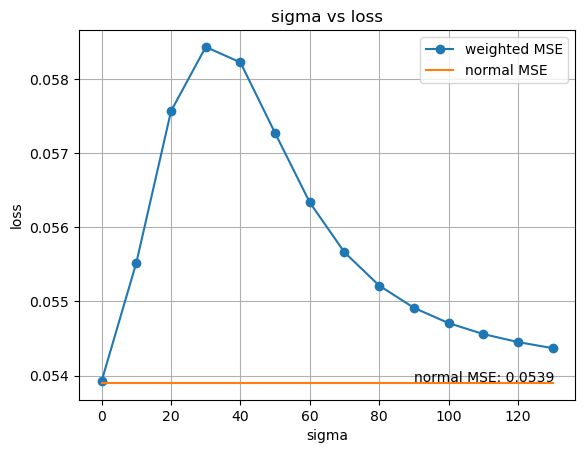

In [8]:
plt.plot([i[0] for i in diff_list], [i[1] for i in diff_list], label='weighted MSE', marker='o')
plt.plot([i[0] for i in diff_list], [0.0539]*len(diff_list), label='normal MSE')
plt.xlabel('sigma')
plt.ylabel('loss')
plt.title('sigma vs loss')
plt.text(90, 0.05392, 'normal MSE: 0.0539')
plt.legend()
plt.grid()

# Vary sigma and multiplier/offset values 

In [9]:
class GaussianWeightedMSELoss:
    def __init__(self, center=(128, 128), sigma=80, multiplier=1, offset=0.1):
        self.center = center
        self.sigma = sigma
        self.multiplier = multiplier
        self.offset = offset
        
    def gaussian_weight(self, shape):
        x, y = torch.meshgrid(torch.arange(shape[-2]), torch.arange(shape[-1]))
        return torch.exp(-((x - self.center[0])**2 + (y - self.center[1])**2) / (2 * self.sigma**2))
    
    def __call__(self, image1, image2):
        weight = self.multiplier*self.gaussian_weight(image1.shape) + self.offset
        print(f'sigma: {self.sigma}, multiplier: {self.multiplier}, offset: {self.offset}')
        print(f'weight max: {weight.max():.4f}, weight min: {weight.min():.4f}')
        weight = weight/torch.mean(weight)
        # print(f'weight sum: {torch.sum(weight):.4f}')
        mse = (image1 - image2)**2
        weighted_mse = mse * weight.expand_as(mse)
        weighted_mse_mean = torch.mean(weighted_mse)
        # print(f'weight MSE max: {weighted_mse.max():.4f}, weight MSE min: {weighted_mse.min():.4f}')

        # different between mse and weighted_mse
        # print(f'MSE diff: {torch.mean(mse - weighted_mse):.4f}')

        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        color = 'gray'
        # blue to red
        # color = 'bwr'
        axes[0].imshow(weight, cmap=color)
        axes[1].imshow(image1[0][0], cmap=color)
        axes[2].imshow(image2[0][0], cmap=color)
        axes[3].imshow(mse[0][0], cmap=color)
        axes[4].imshow(weighted_mse[0][0], cmap=color)
        axes[0].set_title('weight')
        axes[1].set_title('image1')
        axes[2].set_title('image2')
        axes[3].set_title(f'mse: {torch.mean(mse):.4f}')
        axes[4].set_title(f'weighted_mse: {torch.mean(weighted_mse_mean):.4f}')
        # colorbar
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(axes[0].get_images()[0], cax=cbar_ax)
        plt.show()
        
        return weighted_mse_mean

sigma: 0.02, multiplier: 1, offset: 10.01
weight max: 11.0100, weight min: 10.0100


<Figure size 1600x1600 with 0 Axes>

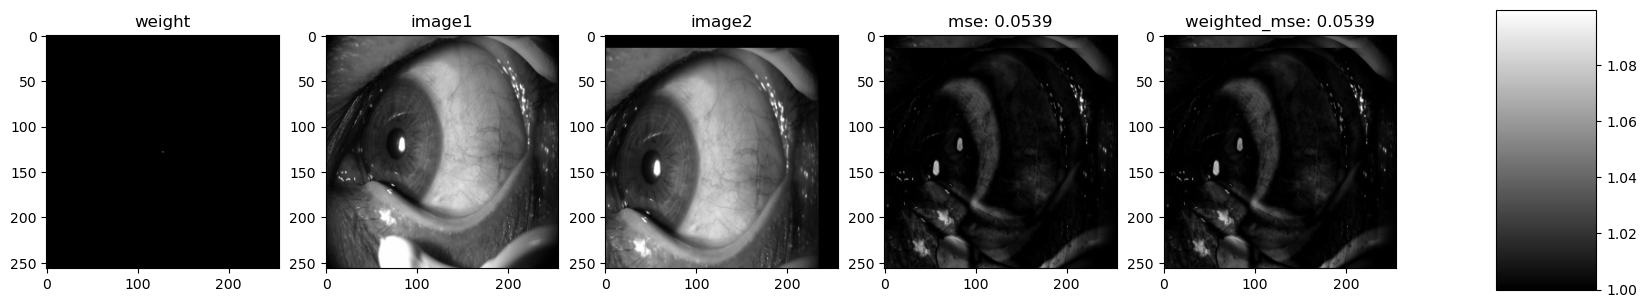

sigma: 20.01, multiplier: 1, offset: 10.01
weight max: 11.0100, weight min: 10.0100


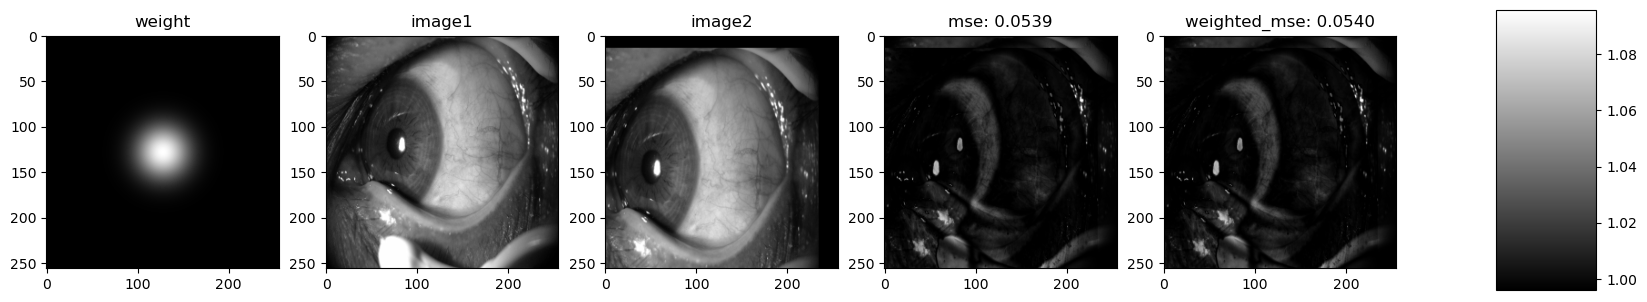

sigma: 90.01, multiplier: 1, offset: 10.01
weight max: 11.0100, weight min: 10.1424


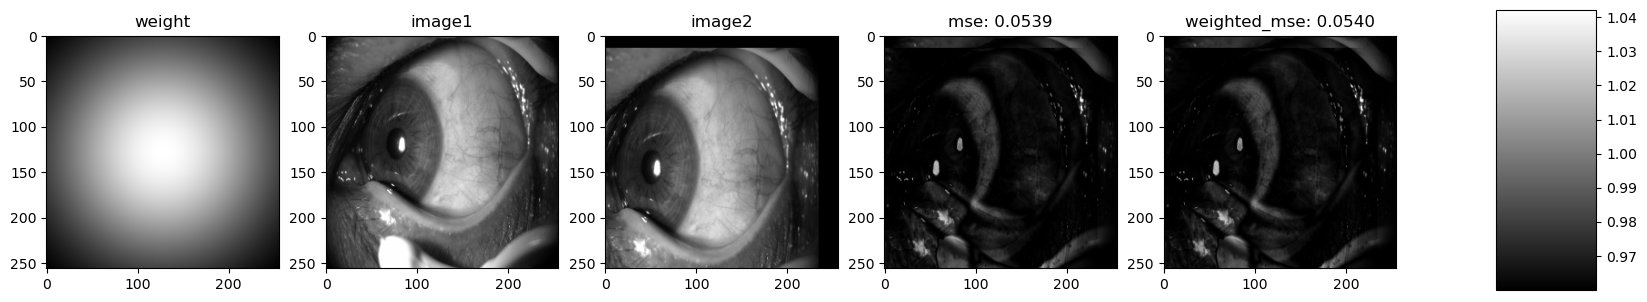

IndexError: list index out of range

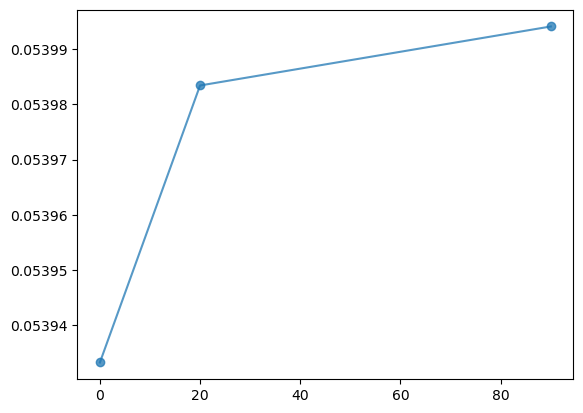

In [10]:
fig = plt.figure(figsize=(16, 16))
# sigma = 10*np.array(range(1, 11), dtype=float)
sigma = [0.01, 20, 90]
offsets = np.linspace(10, 20) + 0.01
for j in offsets:
    diff_list = []
    for i in sigma:
        # print(f'sigma: {i}, offset: {j}')
        image1, image2, _, _, _, _ = list(test_dataset)[1]
        sigma_ = i+0.01
        gaussian_weighted_mse = GaussianWeightedMSELoss(center=center, sigma=sigma_, offset=j)
        # print()
        loss = gaussian_weighted_mse(image1, image2)
        diff_list.append([sigma_, j, loss])

    plt.plot([i[0] for i in diff_list], [i[2] for i in diff_list], label=f'offset: {j:.2f}', marker='o', alpha=0.75)
    plt.text(51, diff_list[5][2], f'{j:.2f}', alpha=0.90)

# plt.plot([i[0] for i in diff_list], [i[2] for i in diff_list], label='weighted MSE', marker='o')
plt.plot([i[0] for i in diff_list], [0.0539]*len(diff_list), label='normal MSE')
plt.xlabel('sigma')
plt.ylabel('loss')
plt.title('sigma vs loss')
plt.text(90, 0.05393, 'normal MSE: 0.0539')
plt.legend()
plt.grid()

# Inverse Gaussian

In [ ]:
class GaussianWeightedMSELoss:
    def __init__(self, center, sigma):
        self.center = center
        self.sigma = sigma
        
    def gaussian_weight(self, shape):
        x, y = torch.meshgrid(torch.arange(shape[-2]), torch.arange(shape[-1]))
        gaussian = torch.exp(-((x - self.center[0])**2 + (y - self.center[1])**2) / (2 * self.sigma**2))
        constant = torch.ones_like(gaussian)*gaussian.max()
        inverted_gaussian = constant - gaussian
        return inverted_gaussian
    
    def __call__(self, image1, image2):
        weight = 1 * self.gaussian_weight(image1.shape)
        print(weight.max(), weight.min())
        mse = (image1 - image2)**2
        weighted_mse = mse * weight.expand_as(mse)
        weighted_mse_mean = torch.mean(weighted_mse)
        print(weighted_mse_mean.max(), weighted_mse_mean.min())

        # fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        # color = 'gray'
        # # blue to red
        # # color = 'bwr'
        # axes[0].imshow(weight, cmap=color)
        # axes[1].imshow(image1[0][0], cmap=color)
        # axes[2].imshow(image2[0][0], cmap=color)
        # axes[3].imshow(mse[0][0], cmap=color)
        # axes[4].imshow(weighted_mse[0][0], cmap=color)
        # axes[0].set_title('weight')
        # axes[1].set_title('image1')
        # axes[2].set_title('image2')
        # axes[3].set_title(f'mse: {torch.mean(mse):.4f}')
        # axes[4].set_title(f'weighted_mse: {torch.mean(weighted_mse_mean):.4f}')
        # plt.show()
        
        return weighted_mse_mean



In [ ]:
sigma = 20*np.array(range(1, 6), dtype=float)

20.0
tensor(1.) tensor(0.)
tensor(0.0514) tensor(0.0514)


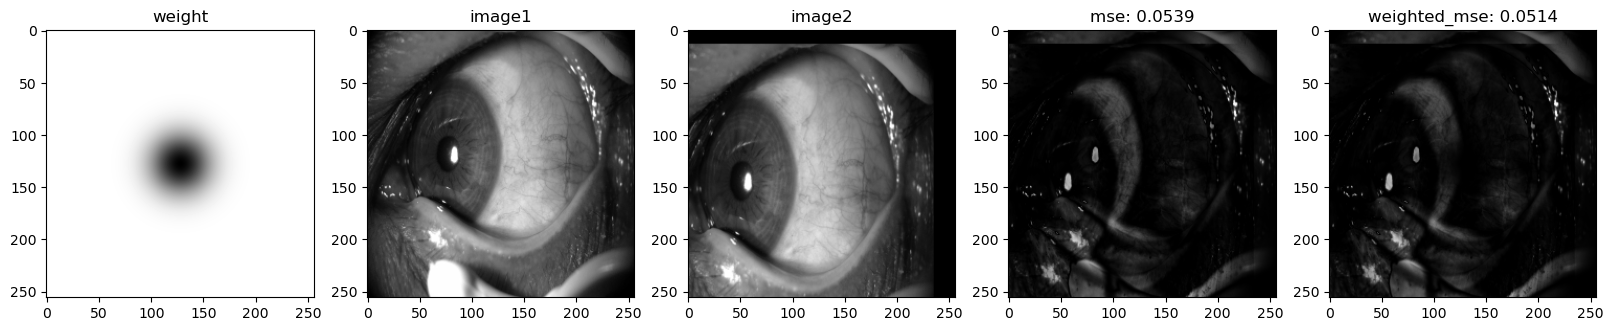

40.0
tensor(1.0000) tensor(0.)
tensor(0.0446) tensor(0.0446)


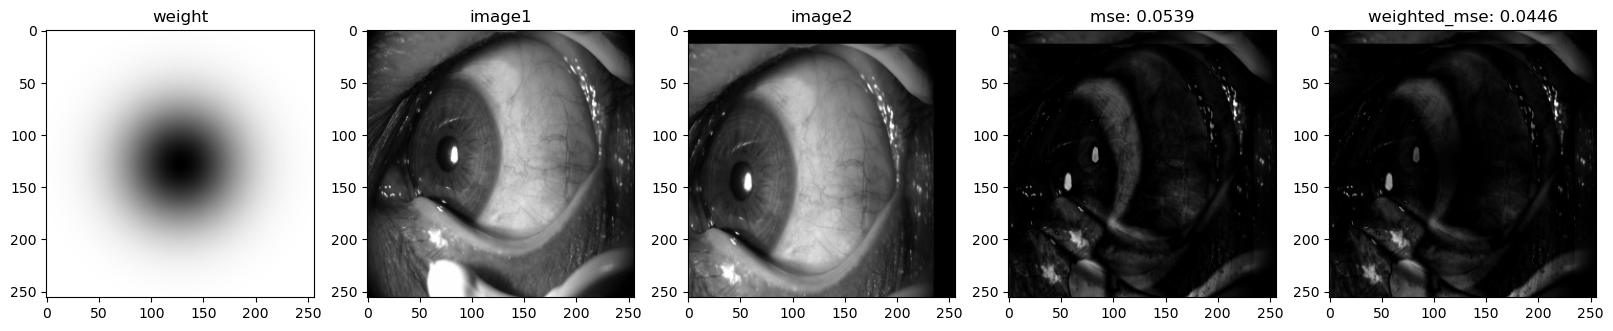

60.0
tensor(0.9894) tensor(0.)
tensor(0.0355) tensor(0.0355)


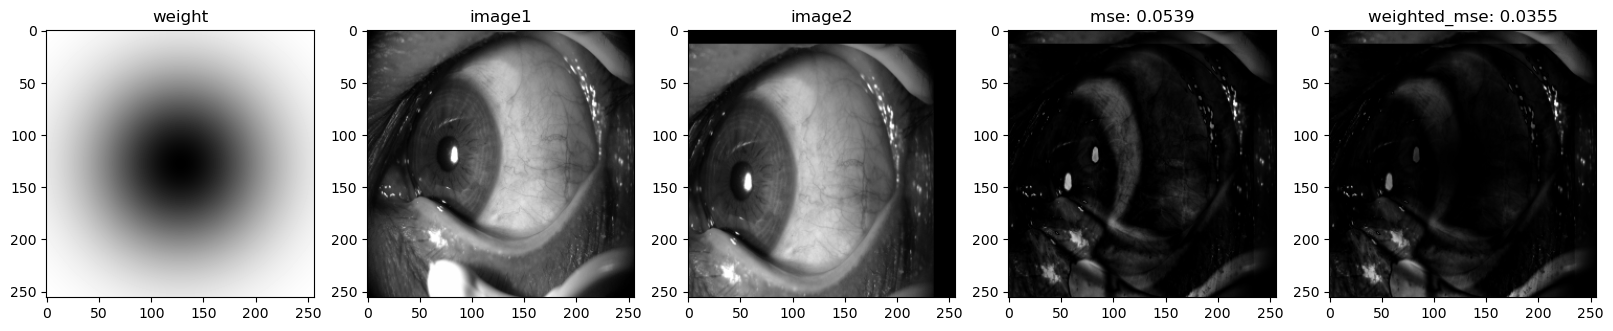

80.0
tensor(0.9227) tensor(0.)
tensor(0.0269) tensor(0.0269)


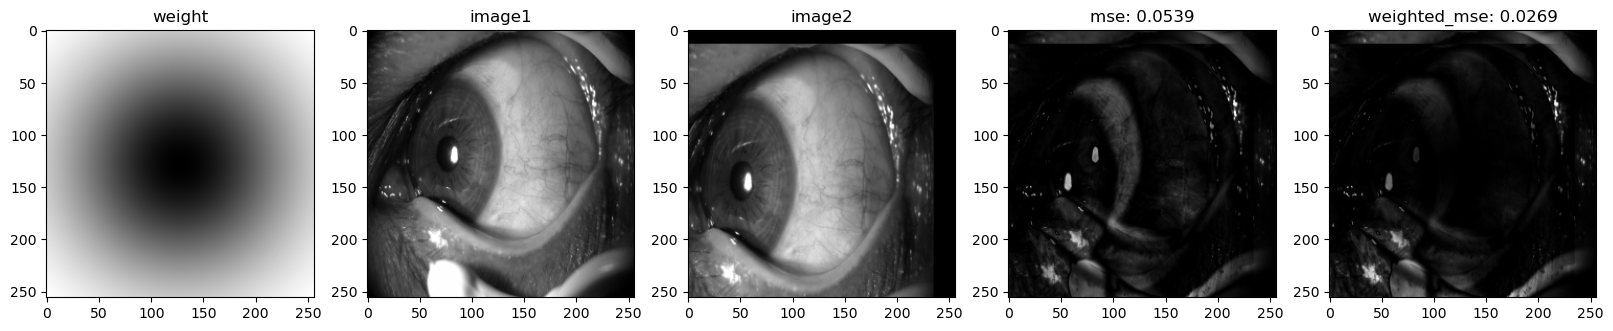

100.0
tensor(0.8057) tensor(0.)
tensor(0.0203) tensor(0.0203)


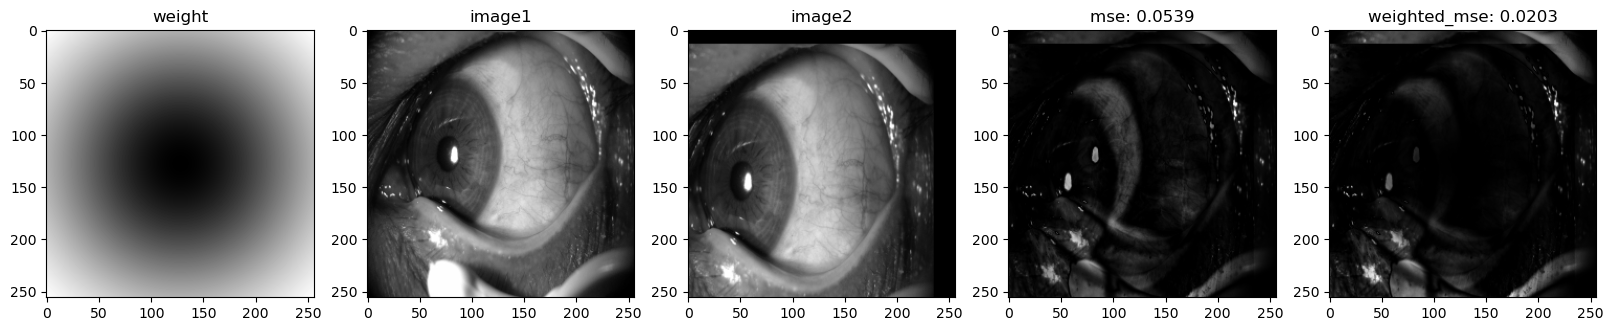

In [ ]:
for i in range(5):
    image1, image2, _, _, _, _ = list(test_dataset)[1]
    print(sigma[i])
    gaussian_weighted_mse = GaussianWeightedMSELoss(center, sigma[i])
    loss = gaussian_weighted_mse(image1, image2)

# Intensity-based MSE loss

In [ ]:
class intensityBased_mse:
    def __init__(self):
        super(intensityBased_mse, self).__init__()
        pass

    def __call__(self, image1, image2):
        # the loss function that puts more weight on the area with higher intensity
        # mse = torch.mean((image1 - image2)**2)
        
        mse = (image1 - image2)**2

        # create weight function as a sigmoid function
        # weight = torch.sigmoid(torch.abs(image1 - image2))
        weight = torch.exp(-torch.abs(image1 - image2))

        weighted_mse = mse*weight.expand_as(mse)
        weighted_mse_mean = torch.mean(weighted_mse)
        # print(weight.shape, mse.shape, weighted_mse.shape)

        # visualize the weight, image1, image2, mse, weighted_mse
        # fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        # color = 'gray'
        # # color = 'bwr'
        # axes[0].imshow(weight[0][0], cmap=color)
        # axes[1].imshow(torch.sigmoid(image1[0][0]), cmap=color)
        # axes[2].imshow(torch.sigmoid(image2[0][0]), cmap=color)
        # axes[3].imshow(mse[0][0], cmap=color)
        # axes[4].imshow(weighted_mse[0][0], cmap=color)
        # axes[0].set_title('weight')
        # axes[1].set_title('image1')
        # axes[2].set_title('image2')
        # axes[3].set_title(f'mse: {torch.mean(mse):.4f}')
        # axes[4].set_title(f'weighted_mse: {weighted_mse_mean:.4f}')
        # plt.show()

        return weighted_mse_mean
    
intensity_based_mse = intensityBased_mse()

# def intensityBased_mse(image1, image2):
#     # the loss function that puts more weight on the area with higher intensity
#     # mse = torch.mean((image1 - image2)**2)
    
#     mse = (image1 - image2)**2

#     # create weight function as a sigmoid function
#     # weight = torch.sigmoid(torch.abs(image1 - image2))
#     weight = torch.exp(-torch.abs(image1 - image2))

#     weighted_mse = mse*weight.expand_as(mse)
#     weighted_mse_mean = torch.mean(weighted_mse)
#     # print(weight.shape, mse.shape, weighted_mse.shape)

#     # visualize the weight, image1, image2, mse, weighted_mse
#     fig, axes = plt.subplots(1, 5, figsize=(20, 4))
#     color = 'gray'
#     # color = 'bwr'
#     axes[0].imshow(weight[0][0], cmap=color)
#     axes[1].imshow(torch.sigmoid(image1[0][0]), cmap=color)
#     axes[2].imshow(torch.sigmoid(image2[0][0]), cmap=color)
#     axes[3].imshow(mse[0][0], cmap=color)
#     axes[4].imshow(weighted_mse[0][0], cmap=color)
#     axes[0].set_title('weight')
#     axes[1].set_title('image1')
#     axes[2].set_title('image2')
#     axes[3].set_title(f'mse: {torch.mean(mse):.4f}')
#     axes[4].set_title(f'weighted_mse: {weighted_mse_mean:.4f}')
#     plt.show()

#     return weighted_mse_mean

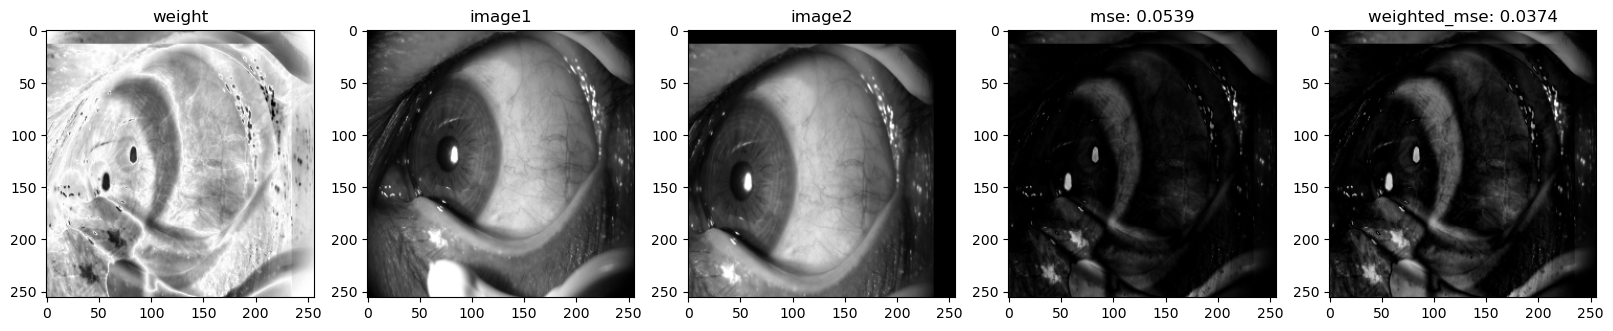

In [ ]:
loss = intensity_based_mse(image1, image2)
# print("Weighted MSE Loss:", loss)

In [ ]:
# for i in range(10):
#     image1, image2 = list(test_dataset)[i]
#     loss = intensity_based_mse(image1, image2)

ValueError: too many values to unpack (expected 2)

# SSIM based loss